In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.transform as transform

# Apply SVD to the correlated 2D observations from last lecture

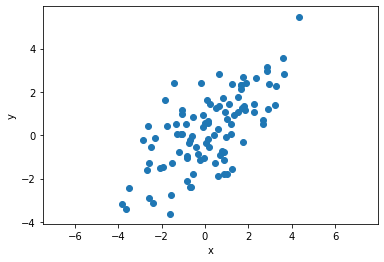

In [2]:
import numpy as np
N = 100          # number of samples
xmean = 0.0
ymean = 0.0
s2_x = 4.0       # variance for x
s2_y = 4.0       # variance for y
s_xy = 3.0       # covariance between x and y

true_covariance_matrix = [[s2_x,s_xy],[s_xy,s2_y]]
# Generate random numbers from a multivariate normal distribution described by the true covariance matrix above
np.random.seed(42)
samples = np.random.multivariate_normal([xmean,ymean],true_covariance_matrix,N)
x=samples[:,0]
y=samples[:,1]

plt.figure()
plt.scatter(x,y)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [3]:
from scipy.linalg import svd
print(samples.shape)
U,S,Vh = svd( samples)
print(U.shape,S.shape,Vh.shape)
m = U.shape[0]
n = Vh.shape[0]

(100, 2)
(100, 100) (2,) (2, 2)


## Plot the orientation of the right singular vectors V

Vh contains the transpose of V, a matrix whose columns represent the 'right singular vectors'.
Below, we plot the vectors defined by the columns of V (rows of Vh), scaled by the square root of the corresponding singular value.

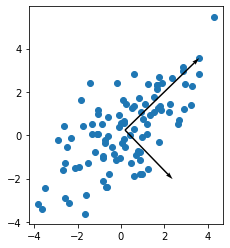

In [4]:
plt.figure()
plt.scatter(x,y)
for i in range(2):
    plt.quiver(np.mean(samples[:,0]),np.mean(samples[:,1]),np.sqrt(S[i])*Vh[i,0],np.sqrt(S[i])*Vh[i,1],scale=1.0,scale_units='x')
ax=plt.gca()
ax.set_aspect('equal')

plt.show()

## Use of SVD for dimensionality reduction

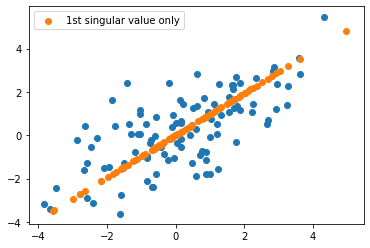

In [5]:
plt.figure()
plt.scatter(x,y)
# represent the data using only the first singular value S[0]:
stmp = np.zeros((m,n))
stmp[0,0] = S[0]
x_reduced = U @ (stmp @ Vh)
plt.scatter(x_reduced[:,0],x_reduced[:,1],label='1st singular value only')
plt.legend()
plt.show()

# Apply SVD to an image

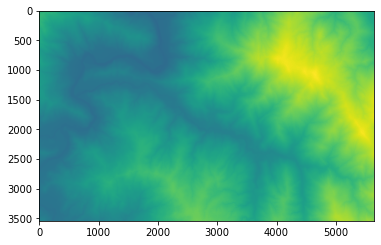

(3544, 5650)
(354, 565)


In [6]:
dem = io.imread('output_be.tif')
# Remove the upper part of the DEM
dem = dem[1000:,:]
# replace the 'no data' values
mask = dem==dem.max()
dem[mask] = 0.0
plt.figure()
plt.imshow(dem)
plt.show()
print(dem.shape)
small_dem = transform.rescale(dem, 0.1, anti_aliasing=False) # re-scale the image
print(small_dem.shape)


In [7]:
from scipy.linalg import svd
U,S,Vh = svd(small_dem)
print(U.shape,S.shape,Vh.shape)
m = U.shape[0]
n = Vh.shape[0]


(354, 354) (354,) (565, 565)


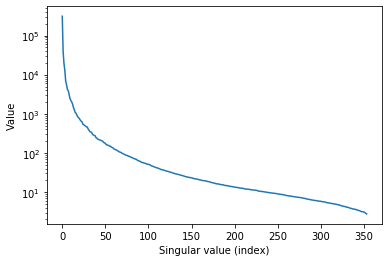

In [8]:
plt.figure()
plt.plot(S)
plt.yscale('log')
plt.xlabel('Singular value (index)')
plt.ylabel('Value')
plt.show()

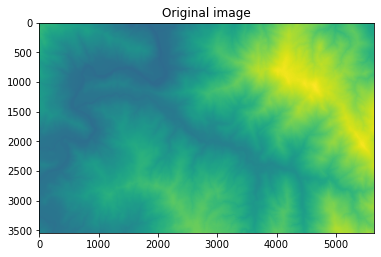

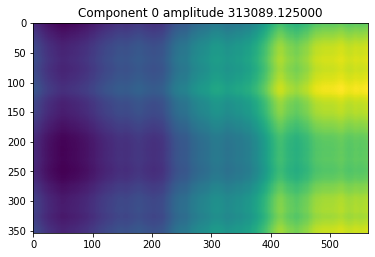

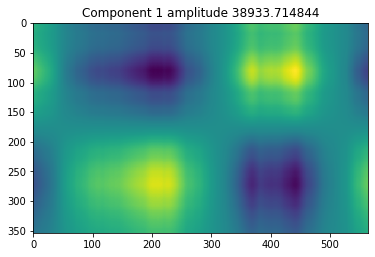

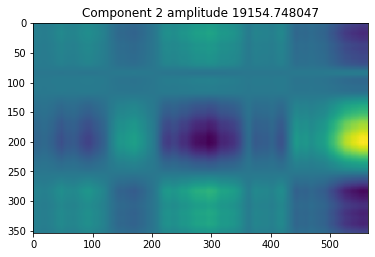

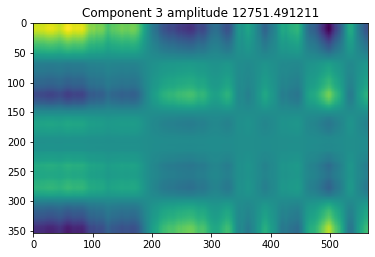

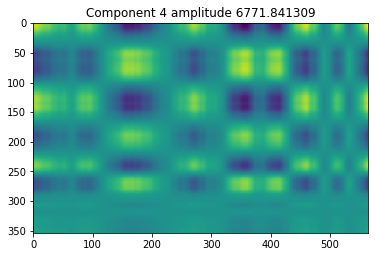

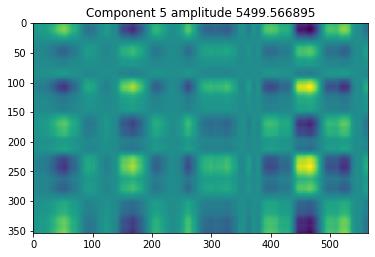

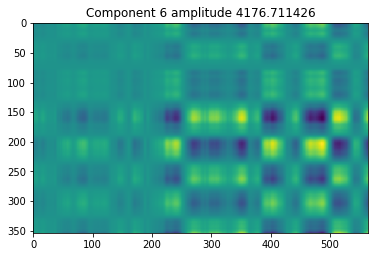

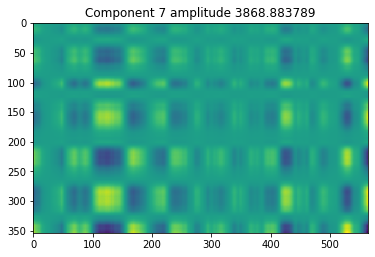

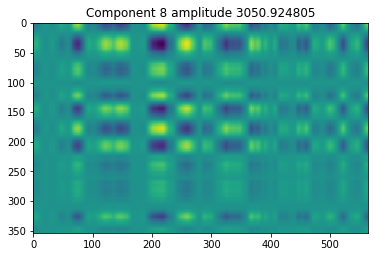

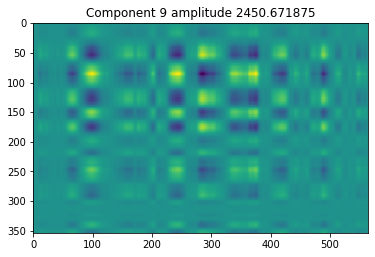

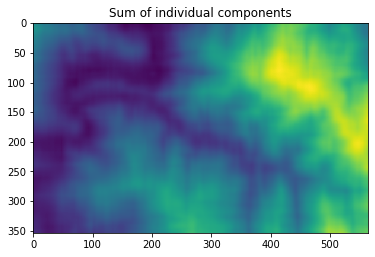

In [9]:
# plot the first couple of singular values
plt.figure()
plt.imshow(dem)
plt.title('Original image')
plt.show()

demsum = np.zeros_like(small_dem) # empty matrix with shape of scaled-down DEM
for i in range(10):
    plt.figure()
    smat = np.zeros((m,n))
    smat[i,i] = S[i] # put in just the ith singular value on the ith diagonal.
    newdem = U @ (smat @ Vh)
    demsum += newdem
    plt.imshow(newdem)
    plt.title('Component {:d} amplitude {:f}'.format(i,S[i]))
    plt.show()

plt.figure()
plt.imshow(demsum)
plt.title('Sum of individual components')
plt.show()

# Application to InSAR data

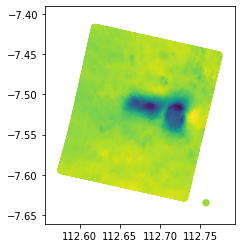

(350972, 2)
(350972, 25)


In [11]:
import scipy.io as sio
displacements_mat = sio.loadmat('LUSI_displacements_Shirzei_etal.mat')
displacement_time_series = displacements_mat['TempDenoise_TimeSeries']

elpx_mat = sio.loadmat('elpx_ll.mat')
latlon = elpx_mat['elpx_ll']

# Plot the data
plt.figure()
plt.scatter(latlon[:,0],latlon[:,1],c=displacement_time_series[:,-1])
ax=plt.gca()
ax.set_aspect('equal','box')
plt.show()

# Get information about size of dataset
print(latlon.shape)
print(displacement_time_series.shape)

In [18]:
# Use SciPy sparse SVD
from scipy.sparse.linalg import svds
U,S,Vh = svds(displacement_time_series, k=6)
print(U.shape,S.shape,Vh.shape)
stmp = np.diag(S)
SVh = stmp @ Vh
print(SVh.shape)
print(S) # Note that Singular values are increasing! Opposite from scikit-learn convention

(350972, 6) (6,) (6, 25)
(6, 25)
[  384.508     482.38876   511.2838    619.48645  1400.1099  11233.978  ]


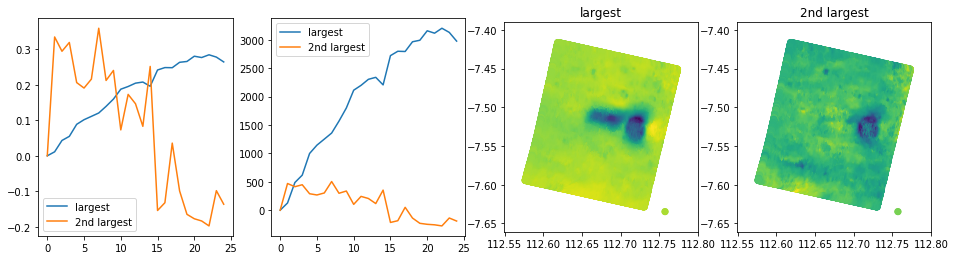

In [19]:
fig,ax = plt.subplots(1,4,figsize=(16,4))
ax[0].plot(Vh[-1,:],label='largest')
ax[0].plot(Vh[-2,:],label='2nd largest')
ax[0].legend()
ax[1].plot(SVh[-1,:],label='largest')
ax[1].plot(SVh[-2,:],label='2nd largest')
ax[1].legend()
ax[2].scatter(latlon[:,0],latlon[:,1],c=U[:,-1])
ax[2].set_title('largest')
ax[3].scatter(latlon[:,0],latlon[:,1],c=U[:,-2])
ax[3].set_title('2nd largest')
ax[2].set_aspect('equal')
ax[3].set_aspect('equal')

plt.show()